In [1]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
import collections
import warnings 
from netCDF4 import default_fillvals
from scipy.stats import hmean

This is an initial notebook for deriving new VIC 5 parameters in the RASM domain. 

It is a work in progress. 

The accompanying excel sheet `deriving_new_parameters_v2.xlsx` and Word Doc `procedure_for_derivation.docx` provide additional citations and details on methods. 

In [2]:
soil_data_vars = collections.OrderedDict()
soil_data_vars['silt'] = 'silt_sl*'
soil_data_vars['sand'] = 'sand_sl*'
soil_data_vars['clay'] = 'clay_sl*'
soil_data_vars['bulk_density'] = 'bulk_density_sl*'
soil_data_vars['organic_fract'] = 'organic_fract*'

# soil data dict with nlayer = 7 (base resolution of data)
soil_data = {}
soil_data_dir = '/u/home/gergel/data/parameters/soil_data/rasm_grid_netcdfs/50km'
for soil_var, soil_wildcard in soil_data_vars.items(): 
    soil_data[soil_var] = xr.open_mfdataset(os.path.join(soil_data_dir, soil_wildcard),
                                            concat_dim='nlayer', 
                                            data_vars='all', 
                                            coords='all')

__If using a different domain than the 50km domain, change domain file in the following cell__ 

In [3]:
domain = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters', 
                                      'domain.lnd.wr50a_ar9v4.100920.nc'))

__Set resolution for filenames__

In [4]:
res = '50km'

# set file extensions 
if res == "50km":
    file_ext = 'wr50a_ar9v4'
elif res == "25km":
    file_ext = 'wr25b_ar9v4'
elif res == "10km":
    raise ValueError("we do not have a domain file at %s so this option has not been implemented" %res)
print("calculating parameters at %s" %res)

calculating parameters at 50km


load CLM PFTs to use for vegetation parameters

In [5]:
# load regridded PFTs 
pfts_data_dir = '/u/home/gergel/data/parameters/pfts/regridded_pfts'
pfts_filename = 'mksrf_landuse_rc2000_c110913_wr50a_ar9v4.nc'
veg_data = xr.open_dataset(os.path.join(pfts_data_dir, pfts_filename))

define soil classification and lookup functions: `is_soil_class`, `is_param_value`, `classify_soil_texture`, and `soil_class_values` along with user-defined errors `SoilClassificationError` and `LookupTableError` for catching bad behavior in the above functions 

In [6]:
def is_soil_class(soil_class):
    '''
    Takes input soil classification and checks to make sure that it is greater than 0 
    (e.g. classified)
    '''
    assert soil_class > 0
        
def is_param_value(parameter):
    '''
    Takes input parameter and checks to be sure that it has been assigned a value 
    (should not be equal to 0 if it has been assigned)
    '''
    assert parameter > 0
    
class SoilClassificationError(Exception):
    pass

class LookupTableError(Exception):
    pass

def classify_soil_texture(sand, clay, silt):
    '''
    this function takes in percent sand and percent clay and classifies it in
    accordance with the ARS Soil Texture classes, listed here in VIC 5 Read the Docs: 
    https://vic.readthedocs.io/en/master/Documentation/soiltext/. 
    '''
    
    soil_class = 0
    
    # sand
    if silt + (1.5 * clay) < 15:
        soil_class = 1
    # loamy sand
    elif silt + (1.5 * clay) >= 15 and silt + (2 * clay) < 30:
        soil_class = 2
    # sandy loam
    elif ((clay >= 7 and clay < 20 and sand > 52 and silt + (2 * clay) >= 30) or 
          (clay < 7 and silt < 50 and silt + (2 * clay) >= 30)):
        soil_class = 3
    # loam
    elif clay >= 7 and clay < 27 and silt >= 28 and silt < 50 and sand <= 52:
        soil_class = 6
    # silt loam
    elif (silt >= 50 and clay >= 12 and clay < 27) or (silt >= 50 and silt < 80 and clay < 12):
        soil_class = 4
    # silt 
    elif silt >= 80 and clay < 12:
        soil_class = 5
    # sandy clay loam
    elif clay >= 20 and clay < 35 and silt < 28 and sand > 45:
        soil_class = 7
    # clay loam
    elif clay >= 27 and clay < 40 and sand > 20 and sand <= 45: 
        soil_class = 9
    # silty clay loam
    elif clay >= 27 and clay < 40 and sand <= 20:
        soil_class = 8
    # sandy clay 
    elif clay >= 35 and sand > 45: 
        soil_class = 10
    # silty clay
    elif clay >= 40 and silt >= 40: 
        soil_class = 11
    elif clay >= 40 and sand <= 45 and silt < 40:
        soil_class = 12
    elif np.isnan(clay):
        soil_class = 12
    
    return(soil_class)

def soil_class_values(soil_class, return_var):
    '''
    takes in a soil class (of type int) and uses lookup tables based on soil class for a number of 
    values that are either directly or indirectly used as VIC parameters. Decides which value to 
    return based on `return_var`, which is a string. 
    
    Valid values for `return_var` include: ksat, b, Wpwp_FRACT, Wcr_FRACT, resid_moist, quartz
    
    This is to get around the current issue with 
    returning multiple output arrays with xr.apply_ufunc. 
    
    Look-up values come from: 
    https://vic.readthedocs.io/en/master/Documentation/soiltext/ 
    Carsel and Parrish 1988, Table 3
    https://ral.ucar.edu/sites/default/files/public/product-tool/noah-multiparameterization-
    land-surface-model-noah-mp-lsm/soil_characteristics.html
    '''
    
    ksat = 0
    b = 0
    porosity = 0
    Wpwp_FRACT = 0
    Wcr_FRACT = 0
    resid_moist = 0
    quartz = 0
    
    # sand
    if soil_class == 1:
        ksat = 38.41
        b = 2.79
        porosity = 0.43
        Wpwp_FRACT = 0.03
        Wcr_FRACT = 0.7 * 0.08
        resid_moist = 0.045
        quartz = 0.92
    # loamy sand
    elif soil_class == 2: 
        ksat = 10.87
        b = 4.26
        porosity = 0.42
        Wpwp_FRACT = 0.06
        Wcr_FRACT = 0.7 * 0.15
        resid_moist = 0.057
        quartz = 0.82
    # sandy loam
    elif soil_class == 3:
        ksat = 5.24
        b = 4.74
        porosity = 0.4
        Wpwp_FRACT = 0.09
        Wcr_FRACT = 0.7 * 0.21
        resid_moist = 0.065
        quartz = 0.60
    # silty loam
    elif soil_class == 4:
        ksat = 3.96
        b = 5.33
        porosity = 0.46
        Wpwp_FRACT = 0.12
        Wcr_FRACT = 0.7 * 0.32
        resid_moist = 0.067
        quartz = 0.25
    # silty
    elif soil_class == 5:
        ksat = 8.59
        # NOTE: Table 3 doesn't have the class silty, using b for silty clay loam
        b = 8.72
        porosity = 0.52
        Wpwp_FRACT = 0.08
        Wcr_FRACT = 0.7 * 0.28
        resid_moist = 0.034
        quartz = 0.10
    # loam
    elif soil_class == 6:
        ksat = 1.97
        b = 5.25
        porosity = 0.43
        Wpwp_FRACT = 0.14
        Wcr_FRACT = 0.7 * 0.29
        resid_moist = 0.078
        quartz = 0.40
    # sandy clay loam
    elif soil_class == 7:
        ksat = 2.4
        b = 6.77
        porosity = 0.39
        Wpwp_FRACT = 0.17
        Wcr_FRACT = 0.7 * 0.27
        resid_moist = 0.100
        quartz = 0.60
    # silty clay loam
    elif soil_class == 8:
        ksat = 4.57
        b = 8.72
        porosity = 0.48
        Wpwp_FRACT = 0.21
        Wcr_FRACT = 0.7 * 0.36
        resid_moist = 0.089
        quartz = 0.10
    # clay loam
    elif soil_class == 9:
        ksat = 1.77
        b = 8.17
        porosity = 0.46
        Wpwp_FRACT = 0.21
        Wcr_FRACT = 0.7 * 0.34
        resid_moist = 0.095
        quartz = 0.35
    # sandy clay
    elif soil_class == 10:
        ksat = 1.19
        b = 10.73
        porosity = 0.41
        Wpwp_FRACT = 0.23
        Wcr_FRACT = 0.7 * 0.31
        resid_moist = 0.100
        quartz = 0.52
    # silty clay
    elif soil_class == 11:
        ksat = 2.95
        b = 10.39
        porosity = 0.49
        Wpwp_FRACT = 0.25
        Wcr_FRACT = 0.7 * 0.37
        resid_moist = 0.070
        quartz = 0.10
    # clay
    elif soil_class == 12:
        ksat = 3.18
        b = 11.55
        porosity = 0.47
        Wpwp_FRACT = 0.27
        Wcr_FRACT = 0.7 * 0.36
        resid_moist = 0.068
        quartz = 0.25
    elif np.isnan(soil_class):
        ksat = np.nan
        b = np.nan
        porosity = np.nan
        Wpwp_FRACT = np.nan
        resid_moist = np.nan
        quartz = np.nan
    else:
        ksat = 1.97
        b = 5.25
        porosity = 0.43
        Wpwp_FRACT = 0.14
        Wcr_FRACT = 0.7 * 0.29
        resid_moist = 0.078
        quartz = 0.40
        
    if ~np.isnan(soil_class):
        # correct for units of VIC 5 parameters
        ksat = ksat * 240 
        Wpwp_FRACT = Wpwp_FRACT / porosity 
        Wcr_FRACT = Wcr_FRACT / porosity
       
    ### NOTE: Wpwp_FRACT MUST be <= Wcr_FRACT, so adjust if necessary 
    if Wpwp_FRACT > Wcr_FRACT:
        Wpwp_FRACT = Wcr_FRACT
    
    if return_var == "ksat":
        return(ksat)
    elif return_var == "b":
        return(b)
    elif return_var == "Wpwp_FRACT":
        return(Wpwp_FRACT)
    elif return_var == "Wcr_FRACT":
        return(Wcr_FRACT)
    elif return_var == "resid_moist":
        return(resid_moist)
    elif return_var == "quartz": 
        return(quartz)

calculate soil types based on percent clay, percent sand and bulk density


In [7]:
# classify_soil_texture(sand, clay, silt)
soil_type_array = xr.apply_ufunc(classify_soil_texture, 
                                 soil_data['sand']['sand'].where(domain.mask == 1), 
                                 soil_data['clay']['clay'].where(domain.mask == 1),  
                                 soil_data['silt']['silt'].where(domain.mask == 1),
                                 dask='allowed',
                                 vectorize=True)

In [8]:
ksat = xr.apply_ufunc(soil_class_values, 
                      soil_type_array,
                      'ksat',
                      dask='allowed',
                      vectorize=True)
quartz = xr.apply_ufunc(soil_class_values, 
                        soil_type_array,
                        'quartz',
                        dask='allowed',
                        vectorize=True)
Wcr_FRACT = xr.apply_ufunc(soil_class_values, 
                           soil_type_array,
                           'Wcr_FRACT',
                           dask='allowed',
                           vectorize=True)
Wpwp_FRACT = xr.apply_ufunc(soil_class_values, 
                            soil_type_array,
                           'Wpwp_FRACT',
                            dask='allowed',
                            vectorize=True)
b = xr.apply_ufunc(soil_class_values, 
                   soil_type_array,
                   'b',
                   dask='allowed',
                   vectorize=True)
resid_moist = xr.apply_ufunc(soil_class_values, 
                             soil_type_array,
                             'resid_moist',
                             dask='allowed',
                             vectorize=True)

load regridded GTOPO 30 data, data var for elevation is called `Band1`, in (m)

In [9]:
gtopo_filename = 'sdat_10003_1_20180525_151136146_wr50a_ar9v4.nc'
gtopo = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/gtopo30', gtopo_filename))
elev = gtopo['Band1']

load regridded WORLDCLIM climate data for annual t and p 

In [10]:
clim_direc = '/u/home/gergel/data/parameters/world_clim_data/50km'
prec = xr.open_mfdataset(os.path.join(clim_direc, 'prec*'),
                                      concat_dim='time', 
                                      data_vars=['prec'], 
                                      coords='all')

# aggregate to annual, need average annual precip
annual_precip = prec['prec'].sum('time')

temp = xr.open_mfdataset(os.path.join(clim_direc, 'tavg*'),
                                      concat_dim='time', 
                                      data_vars='all', 
                                      coords='all')
tavg = temp['tavg'].mean('time')

load ERA-Interim roughness for vegetation roughness

In [11]:
'''era_interim_direc = "/p/cwfs/gergel/compare_data/era-interim/flux_files/post_processed/monthly_means-wodc"
era_interim = xr.open_mfdataset(os.path.join(era_interim_direc, 'wrf-*'))
roughness = era_interim['znt'].mean('time')'''

'era_interim_direc = "/p/cwfs/gergel/compare_data/era-interim/flux_files/post_processed/monthly_means-wodc"\nera_interim = xr.open_mfdataset(os.path.join(era_interim_direc, \'wrf-*\'))\nroughness = era_interim[\'znt\'].mean(\'time\')'

# Note: need to extract roughness values because of the nature of the attributes

calculate Cv from PFTs

In [12]:
def calculate_cv_pft(gridcell_pft):
    '''
    takes a percent PFT for a gridcell and returns the fraction of gridcell coverage for that PFT
    '''
    
    return(gridcell_pft / 100.0)

In [13]:
cv = xr.apply_ufunc(calculate_cv_pft, 
                    veg_data['PCT_PFT'].where(domain.mask == 1),
                    dask='allowed',
                    vectorize=True)

calculate number of active PFTs, `Nveg` 

In [14]:
def calculate_nveg_pfts(gridcell_pfts):
    '''
    takes in the 17 PFTs for a gridcell and returns the number of active veg types for that gridcell,
    e.g. the number of PCT_PFTs that is greater than 0
    '''
    return(np.count_nonzero(gridcell_pfts))

In [15]:
# make version of veg_data['PCT_PFT'] that has 0s for bare soil/water class (pft=0)
veg_data['PCT_PFT'].values[0, :, :] = 0

In [16]:
Nveg = xr.apply_ufunc(calculate_nveg_pfts,
                      veg_data['PCT_PFT'].where(domain.mask == 1),
                      dask='allowed',
                      input_core_dims=[['pft']],
                      vectorize=True)

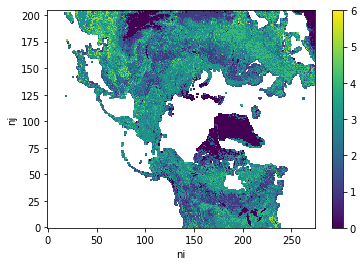

In [17]:
Nveg.where(domain.mask == 1).plot()

import LAI and vegetation height, `MONTHLY_LAI` and `MONTHLY_HEIGHT_TOP`

In [18]:
lai_file = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/lai/regridded_lai', 
                                   'mksrf_lai_78pfts_simyr2005.c170413_wr50a_ar9v4_lai.nc'))

In [19]:
veg_height_file = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters/lai/regridded_lai', 
                                'mksrf_lai_78pfts_simyr2005.c170413_wr50a_ar9v4_veg_height.nc'))

LAI and veg_height from CLM and `PCT_PFT` from CLM have a different number of PFTs (`PCT_PFT` has one more PFT, 17 vs 16). The extra PFT in `PCT_PFT` has `PCT_PFT` = 0 over the entire RASM domain, so I just slice the LAI and veg_height from the 0th PFT (water/bare soil) and concatenate it for the 16th PFT. 

In [20]:
lai_slice = lai_file['MONTHLY_LAI'].isel(pft = 0)
vegheight_slice = veg_height_file['MONTHLY_HEIGHT_TOP'].isel(pft=0)

In [21]:
lai = xr.concat([lai_file['MONTHLY_LAI'], lai_slice], dim='pft')
veg_height = xr.concat([veg_height_file['MONTHLY_HEIGHT_TOP'], vegheight_slice], dim='pft')

`veg_rough` = 0.123 * `veg_height`

`displacement` = 0.67 * `veg_height`

In [22]:
veg_rough = 0.123 * veg_height
displacement = 0.67 * veg_height

displacement.values[displacement.values == 0] = 1.0
# displacement.values[:, 0, :, :] = 0

In [23]:
displacement

<xarray.DataArray 'MONTHLY_HEIGHT_TOP' (time: 12, pft: 17, nj: 205, ni: 275)>
array([[[[ 1., ...,  1.],
         ..., 
         [ 1., ...,  1.]],

        ..., 
        [[ 1., ...,  1.],
         ..., 
         [ 1., ...,  1.]]],


       ..., 
       [[[ 1., ...,  1.],
         ..., 
         [ 1., ...,  1.]],

        ..., 
        [[ 1., ...,  1.],
         ..., 
         [ 1., ...,  1.]]]], dtype=float32)
Coordinates:
  * time     (time) float64 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5 10.5 11.5 12.5
    xc       (nj, ni) float64 189.2 189.4 189.6 189.7 189.9 190.1 190.2 ...
    yc       (nj, ni) float64 16.53 16.78 17.02 17.27 17.51 17.76 18.0 18.25 ...
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 ...
Dimensions without coordinates: nj, ni

map albedo, root zone fraction and root zone depth based on vegetation type. see `deriving_new_parameters_v2.xlsx` sheet titled `PFT-NLDAS Mapping` for mapping between NLDAS vegetation classes (used in old VIC 5 parameters) and CLM PFTs. This mapping is based on obvious relationships and some approximations (used for PFTs 8-11).

In [24]:
def map_pft_to_nldas_class(pft):
    '''
    this function takes in a pft and maps it to an NLDAS veg class for using NLDAS VIC 5 veg-class 
    specific parameters. 
    '''
    # bare 
    if pft == 0:
        nldas = 11
    # NET - temperate
    elif pft == 1:
        nldas = 0
    # NET - boreal
    elif pft == 2:
        nldas = 0
    # NDT - boreal
    elif pft == 3:
        nldas = 1
    # BET - tropical
    elif pft == 4:
        nldas = 2
    # BET - temperate
    elif pft == 5:
        nldas = 2
    # BDT - tropical
    elif pft == 6:
        nldas = 3
    # BDT - temperate
    elif pft == 7:
        nldas = 3
    # BDT - boreal
    elif pft == 8:
        nldas = 3
    # BES - temperate
    elif pft == 9:
        nldas = 8
    # BDS - temperate
    elif pft == 10:
        nldas = 8
    # BDS - boreal
    elif pft == 11:
        nldas = 8
    # C3 arctic grass
    elif pft == 12:
        nldas = 9
    # C3 grass
    elif pft == 13:
        nldas = 9
    # C4 grass
    elif pft == 14:
        nldas = 9
    # crops
    elif pft == 15:
        nldas = 10
    elif pft == 16: 
        nldas = 2
    else: 
        raise ValueError("this is not a PFT")
    return(nldas)

In [25]:
def is_overstory(nldas_class):
    '''
    function takes in an NLDAS class, if NLDAS class is 1-6 returns 1 (class has an overstory)
    if NLDAS class 7-12, return 0 (class does not have an overstory)
    '''
    if nldas <= 5:
        return(1)
    else:
        return(0)

get albedo values from VIC 5 parameters for NLDAS classes, map to CLM PFTs

In [26]:
old_params = xr.open_dataset(os.path.join('/u/home/gergel/data', 
                                          'vic_params_wr50a_vic5.0.dev_20160328.nc'))

create array that is the size of (nj, ni, pft, root_zone) to operate on

In [27]:
masknan_vals = domain['mask'].where(domain['mask'] == 1).values
nj = 205
ni = 275
num_veg = 17


arr_months = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                    masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                    masknan_vals, masknan_vals, masknan_vals, masknan_vals)), 
                        axis=2)
arr_nlayer = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals)), 
                        axis=2)

arr_rootzone = np.rollaxis(np.dstack((masknan_vals, masknan_vals)), 
                        axis=2)

arr_veg_classes = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals, masknan_vals, masknan_vals, masknan_vals, 
                                         masknan_vals)), 
                              axis=2)
arr_veg_classes_rootzone = np.vstack((arr_rootzone, arr_rootzone, arr_rootzone, arr_rootzone, 
                                      arr_rootzone, arr_rootzone, arr_rootzone, arr_rootzone, 
                                      arr_rootzone, arr_rootzone, arr_rootzone, arr_rootzone, 
                                      arr_rootzone, arr_rootzone, arr_rootzone,
                                      arr_rootzone, arr_rootzone)).reshape(num_veg, 2, nj, ni)
arr_veg_classes_month = np.vstack((arr_months, arr_months, arr_months, arr_months, arr_months, 
                                   arr_months, arr_months, arr_months, arr_months, arr_months, 
                                   arr_months, arr_months, arr_months, arr_months, arr_months, 
                                   arr_months, arr_months,)).reshape(num_veg, 12, nj, ni)

create Dataset for variables and define data_vars 

In [28]:
params = xr.Dataset()

# define fillvals
fillval_f = default_fillvals['f8']
fillval_i = default_fillvals['i4']

# assign veg class indexing
params['veg_class'] = xr.DataArray(np.arange(1, 18), dims='veg_class', 
                                   attrs={'long_name': "vegetation class"})
params['nlayer'] = xr.DataArray(np.arange(0, 3), dims='nlayer')

params['Cv'] = xr.DataArray(cv,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Fraction of grid cell covered by vegetation tile",
                                        'units': "fraction", 'long_name': "Cv"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['Nveg'] = xr.DataArray(Nveg,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "Number of vegetation tiles in the grid cell", 
                                          'units': "N/A", 'long_name': "Nveg"},
                                   encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})

params['trunk_ratio'] = xr.DataArray(arr_veg_classes,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Ratio of total tree height that is trunk \
                                 (no branches) \
                                        The default value has been 0.2",
                                 'units': "fraction", 'long_name': "Cv"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['rarc'] = xr.DataArray(arr_veg_classes,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Architectural resistance of vegetation type \(~2 s/m)",
                                        'units': "s/m", 'long_name': "rarc"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['rmin'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Minimum stomatal resistance of vegetation type (~100 s/m)"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['wind_h'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Height at which wind speed is measured",
                                        'units': "m", 'long_name': "wind_h"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['RGL'] = xr.DataArray(np.copy(arr_veg_classes),
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Minimum incoming shortwave radiation at which there will be \
                                        transpiration. For trees this is about 30 W/m^2, for crops about 100 W/m^2",
                                        'units': "W/m^2", 'long_name': "RGL"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['rad_atten'] = xr.DataArray(arr_veg_classes,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Radiation attenuation factor. Normally set to 0.5, though may \
                                        need to be adjusted for high latitudes",
                                        'units': "fraction", 'long_name': "rad_atten"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['wind_atten'] = xr.DataArray(arr_veg_classes,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Wind speed attenuation through the overstory. The default value \
                                        has been 0.5",
                                        'units': "fraction", 'long_name': "wind_atten"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['albedo'] = xr.DataArray(arr_veg_classes_month,
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Shortwave albedo for vegetation type",
                                                'units': "fraction", 'long_name': "albedo"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

params['LAI'] = xr.DataArray(lai.values.reshape(num_veg, 12, nj, ni),
                                 dims=('veg_class','month','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc, 'month': old_params.month},
                                 attrs={'description': "Leaf Area Index, one per month",
                                        'units': "N/A", 'long_name': "LAI"},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['overstory'] = xr.DataArray(arr_veg_classes,
                                 dims=('veg_class','nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 attrs={'description': "Flag to indicate whether or not the current vegetation type \
                                        has an overstory (TRUE for overstory present (e.g. trees), FALSE for \
                                        overstory not present (e.g. grass))",
                                        'units': "N/A", 'long_name': "overstory"},
                                 encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})
params['displacement'] = xr.DataArray(displacement.values.reshape(num_veg, 12, nj, ni), 
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'month': old_params['month'], 'xc': domain.xc, 
                                                 'yc': domain.yc},
                                         attrs={'description': "Vegetation displacement height (typically 0.67 \
                                                * vegetation height)",
                                                'units': "m", 'long_name': "displacement"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['veg_rough'] = xr.DataArray(veg_rough.values.reshape(num_veg, 12, nj, ni),
                                         dims=('veg_class','month','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Vegetation roughness length (typically 0.123 \
                                                * vegetation height)",
                                                'units': "m", 'long_name': "veg_rough"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [29]:
params['elev'] = xr.DataArray(elev.values,
                                dims=('nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "Average elevation of grid cell", 
                                              'units': "m", 'long_name': "elev"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['avg_T'] = xr.DataArray(tavg.values,
                                dims=('nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "Average soil temperature, used as the bottom boundary \
                                        for soil heat flux solutions", 
                                        'units': "C", 'long_name': "avg_T"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['annual_prec'] = xr.DataArray(annual_precip.values,
                                dims=('nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "Average annual precipitation", 
                                              'units': "mm", 'long_name': "annual_prec"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
roughness = np.copy(masknan_vals)
roughness[np.nonzero(masknan_vals)] = 0.001
params['rough'] = xr.DataArray(roughness,
                                dims=('nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "Surface roughness of bare soil", 
                                              'units': "m", 'long_name': "rough"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

define `trunk_ratio`, `rarc`, `rmin`, `wind_h`, `RGL`, `rad_atten`, `wind_atten`, `overstory`

In [30]:
# trunk ratio, rarc, rad_atten
trunk_ratio = np.copy(arr_veg_classes)
params['trunk_ratio'].values = trunk_ratio * 0.2
# adjust for bare soil 
params['trunk_ratio'].values[0, :, :] = 0.0

rarc = np.copy(arr_veg_classes)
params['rarc'].values = rarc * 60

rad_atten = np.copy(arr_veg_classes)
params['rad_atten'].values = rad_atten * 0.5
# adjust for bare soil 
params['rad_atten'].values[0, :, :] = 0.0

wind_atten = np.copy(arr_veg_classes)
params['wind_atten'].values = wind_atten * 0.5
# adjust for bare soil 
params['wind_atten'].values[0, :, :] = 0.0

In [31]:
# rmin, wind_h
for pft in veg_data.pft.values:
    # get nldas mapping from pft
    nldas = map_pft_to_nldas_class(pft)
    if nldas >= 0 and nldas <= 3:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=0).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=0).mean())
    elif nldas == 4:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=4).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=4).mean())
    elif nldas >= 5 and nldas <= 6:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=5).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=5).mean())
    elif nldas >= 7 and nldas <= 8:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=7).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=7).mean())
    elif nldas == 9:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=9).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=9).mean())
    elif nldas == 10:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=10).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=10).mean())
    elif nldas == 11:
        rmin = np.asscalar(old_params.rmin.isel(veg_class=11).mean())
        wind_h = np.asscalar(old_params.wind_h.isel(veg_class=11).mean())
    params['rmin'].values[pft, :, :] = np.ones((1, 205, 275)) * rmin
    params['wind_h'].values[pft, :, :] = np.ones((1, 205, 275)) * wind_h

In [32]:
# RGL
for pft in veg_data.pft.values:
    # get nldas mapping from pft
    nldas = map_pft_to_nldas_class(pft)
    if nldas >= 0 and nldas <= 3:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=0).mean())
    elif nldas >= 4 and nldas <= 5:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=4).mean())
    elif nldas >= 6 and nldas <= 8:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=6).mean())
    elif nldas >= 9 and nldas <= 10:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=9).mean())
    elif nldas == 11:
        rgl = np.asscalar(old_params.wind_h.isel(veg_class=11).mean())
    params['RGL'].values[pft, :, :] = np.ones((1, 205, 275)) * rgl

In [33]:
# overstory
for pft in veg_data.pft.values:
    nldas = map_pft_to_nldas_class(pft)
    if nldas > 6:
        # no overstory
        overstory = 0
    else: 
        overstory = 1
    params['overstory'].values[pft, :, :] = np.ones((1, 205, 275)) * overstory

# adjust bare soil, it should obviously not have an overstory
params['overstory'].values[0, :, :] = np.ones((1, 205, 275)) * 0.0

In [34]:
def calc_root_fract(cv, pft, root_zone):
    # root fract is not homogenous across veg classes 
    nldas = map_pft_to_nldas_class(int(float(pft)))
    if cv > 0:
        if nldas == 0 or nldas == 1 or nldas == 2 or nldas == 3 or nldas == 4 or nldas == 5: 
            if root_zone == "1":
                root_fract = 0.3
            else: 
                root_fract = 0.7
        elif nldas == 6 or nldas == 7:
            if root_zone == "1":
                root_fract = 0.6
            else: 
                root_fract = 0.4
        elif nldas == 8 or nldas == 9 or nldas == 10: 
            if root_zone == "1":
                root_fract = 0.7
            else:
                root_fract = 0.3
        elif nldas == 11:
            if root_zone == "1":
                root_fract = 0.0
            else: 
                root_fract = 0.0
        return(root_fract)
    elif cv == 0:
        return(0)
    else:
        return(cv)

In [35]:
def calc_root_depth_rz1(cv):
    '''
    takes in: 
    cv: DataArray
    '''
    # root depth is homogenous across veg classes 
    # assuming root zone is 1
    if cv > 0:
        root_depth = 0.3
    else:
        root_depth = 0.0
    return(root_depth)
def calc_root_depth_rz2(cv):
    '''
    takes in: 
    cv: DataArray
    '''
    # root depth is homogenous across veg classes 
    # assuming root zone is 2
    if cv > 0:
        root_depth = 0.7
    else:
        root_depth = 0.0
    return(root_depth)

In [36]:
root_depth_rz1 = xr.apply_ufunc(calc_root_depth_rz1,
                           params['Cv'].where(domain.mask == 1), 
                           dask='allowed',
                           vectorize=True)
root_depth_rz2 = xr.apply_ufunc(calc_root_depth_rz2,
                           params['Cv'].where(domain.mask == 1), 
                           dask='allowed',
                           vectorize=True)
root_depth = xr.concat([root_depth_rz1, root_depth_rz2],
                      dim='root_zone').transpose('veg_class', 'root_zone', 'nj', 'ni')
# adjust for bare soil/water
# root_depth.values[0, :, :, :] = 0.0

In [37]:
# root fract 

rz = 0
for pft in veg_data.pft.values:
    if pft == 0:
        root_fract_rz1 = xr.apply_ufunc(calc_root_fract,
                                        params['Cv'].isel(veg_class=pft),
                                        str(pft),
                                        str(rz),
                                        dask='allowed',
                                        vectorize=True)
    else: 
        root_fract_rz1 = xr.concat([root_fract_rz1, xr.apply_ufunc(calc_root_fract,
                                                                   params['Cv'].isel(veg_class=pft),
                                                                   str(pft),
                                                                   str(rz),
                                                                   dask='allowed',
                                                                   vectorize=True)],
                                  dim='veg_class')
rz = 1
for pft in veg_data.pft.values:
    if pft == 0:
        root_fract_rz2 = xr.apply_ufunc(calc_root_fract,
                                        params['Cv'].isel(veg_class=pft), 
                                        str(pft),
                                        str(rz),
                                        dask='allowed',
                                        vectorize=True)
    else: 
        root_fract_rz2 = xr.concat([root_fract_rz2, xr.apply_ufunc(calc_root_fract,
                                                                   params['Cv'].isel(veg_class=pft), 
                                                                   str(pft),
                                                                   str(rz),
                                                                   dask='allowed',
                                                                   vectorize=True)],
                                  dim='veg_class')
        
root_fract = xr.concat([root_fract_rz1, root_fract_rz2], dim='root_zone').transpose('veg_class', 'root_zone', 'nj', 'ni')
# root_fract.values[0, :, :, :] = 0.0

In [38]:
params['root_depth'] = xr.DataArray(root_depth,
                                         dims=('veg_class','root_zone','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Root zone thickness (sum of depths is total depth of \
                                                 root penetration)",
                                                'units': "m", 'long_name': "root_depth"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['root_fract'] = xr.DataArray(root_fract,
                                         dims=('veg_class','root_zone','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Fraction of root in the current root zone",
                                                'units': "fraction", 'long_name': "root_fract"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [39]:
# loop over pft classes and months 
for pft in veg_data.pft.values:
    for month in old_params.month.values:
        nldas = map_pft_to_nldas_class(pft)
        month_index = month - 1
        params['albedo'].values[pft, month_index, :, :] = np.copy(old_params['albedo'].isel(veg_class=nldas)
                                                      .isel(month=month_index).values)

# calibratable parameters: D1, D2, D3, b_i

# and soil depths 

baseflow parameters: Ds, Dsmax, Ws

In [40]:
params['Ds'] = xr.DataArray(old_params['Ds'].values,
                              dims=('nj', 'ni'),
                              coords={'xc': domain.xc, 'yc': domain.yc},
                              attrs={'description': "Fraction of Dsmax where non-linear baseflow begins", 
                                         'units': "fraction", 'long_name': "Ds"},
                                 encoding={"_FillValue": fillval_f,
                                           "Coordinates": "xc yc"})
params['Ws'] = xr.DataArray(old_params['Ws'].values,
                              dims=('nj', 'ni'),
                              coords={'xc': domain.xc, 'yc': domain.yc},
                              attrs={'description': "Fraction of maximum soil moisture where non-linear baseflow occurs", 
                                              'units': "fraction", 'long_name': "Ws"},
                                 encoding={"_FillValue": fillval_f,
                                           "Coordinates": "xc yc"})
params['Dsmax'] = xr.DataArray(old_params['Dsmax'].values,
                              dims=('nj', 'ni'),
                              coords={'xc': domain.xc, 'yc': domain.yc},
                              attrs={'description': "Fraction of maximum soil moisture where non-linear baseflow occurs", 
                                              'units': "fraction", 'long_name': "Dsmax"},
                                 encoding={"_FillValue": fillval_f,
                                           "Coordinates": "xc yc"})

load hydroclimate classes for bi and soil depths

In [41]:
hydro_classes = xr.open_dataset(os.path.join('/u/home/gergel/data/parameters',
                                             'hydroclimate_masks.nc'))

b_i (`infilt`)

In [42]:
bi = np.copy(masknan_vals)
bi[np.nonzero(hydro_classes['arid'].values)] = 0.05
bi[np.nonzero(hydro_classes['temperate_dry'].values)] = 0.05
bi[np.nonzero(hydro_classes['cold_dry_perma'].values)] = 0.3
bi[np.nonzero(hydro_classes['cold_dry_noperma'].values)] = 0.5
bi[np.nonzero(hydro_classes['cold_dry_noperma'].values)] = 0.5
bi[np.nonzero(hydro_classes['cold_wds_ws_perma'].values)] = 0.3
bi[np.nonzero(hydro_classes['cold_wds_ws_noperma'].values)] = 0.05
bi[np.nonzero(hydro_classes['cold_wds_cs_perma'].values)] = 0.3
bi[np.nonzero(hydro_classes['cold_wds_cs_noperma'].values)] = 0.5
bi[np.nonzero(hydro_classes['polar'].values)] = 0.1

params['infilt'] = xr.DataArray(bi,
                              dims=('nj', 'ni'),
                              coords={'xc': domain.xc, 'yc': domain.yc},
                              attrs={'description': "Fraction of maximum soil moisture where non-linear baseflow occurs", 
                                              'units': "fraction", 'long_name': "infilt"},
                                 encoding={"_FillValue": fillval_f,
                                           "Coordinates": "xc yc"})

soil depths (`depth`)

In [43]:
d1 = np.copy(masknan_vals)
d2 = np.copy(masknan_vals)
d3 = np.copy(masknan_vals)
d1[np.nonzero(domain.mask.values)] = 0.1
d3[np.nonzero(domain.mask.values)] = 0.5

d2[np.nonzero(hydro_classes['arid'].values)] = 2.0
d2[np.nonzero(hydro_classes['temperate_dry'].values)] = 2.0
d2[np.nonzero(hydro_classes['cold_dry_perma'].values)] = 0.5
d2[np.nonzero(hydro_classes['cold_dry_noperma'].values)] = 0.4
d2[np.nonzero(hydro_classes['cold_dry_noperma'].values)] = 0.5
d2[np.nonzero(hydro_classes['cold_wds_ws_perma'].values)] = 2.0
d2[np.nonzero(hydro_classes['cold_wds_ws_noperma'].values)] = 0.5
d2[np.nonzero(hydro_classes['cold_wds_cs_perma'].values)] = 1.1
d2[np.nonzero(hydro_classes['cold_wds_cs_noperma'].values)] = 0.3
d2[np.nonzero(hydro_classes['polar'].values)] = 0.1

# arr_nlayer = np.rollaxis(np.dstack((masknan_vals, masknan_vals, masknan_vals)), axis=2)

depths = np.rollaxis(np.dstack((d1, d2, d3)), axis=2)

params['depth'] = xr.DataArray(depths,
                                dims=('nlayer','nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "Thickness of each soil moisture layer",
                                   'units': "m", 'long_name': "depth"},
                                encoding={"_FillValue": fillval_f,
                                       "Coordinates": "xc yc"})

aggregate ISRIC soil data to VIC soil depths

first need array of soil depths 

In [44]:
soil_depths = params['depth'].sum(axis=0)

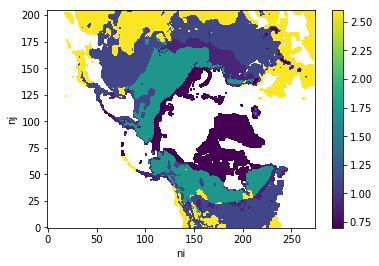

In [45]:
soil_depths.where(domain.mask ==1).plot()

In [46]:
print("max soil depth is %.1f m" % soil_depths.max())

max soil depth is 2.6 m


In [47]:
def calculate_first_layer_harmonic_mean(sl1, sl2):
    '''
    takes in two values over which to calculate the harmonic mean, uses hmean from scipy.stats package
    '''
    arr = np.array([sl1, sl2])
    return(hmean(arr))

def calculate_second_layer_harmonic_mean(sl3, sl4, sl5, sl6, sl7, total_depth):
    '''
    sl3: 0.15m, sl4: 0.3m, sl5: 0.6m, sl6: 1m, sl7: 2m
    takes in sl3-7 and returns harmonic mean of whatever layers are included in the profile
    '''
    d1 = 0.1 # spatially homogenous first layer soil depth
    d3 = 0.5 # spatially homogenous third layer soil depth
    second_layer = total_depth - (d1 + d3)
    if second_layer < 0.3:
        return(sl3)
    elif second_layer >= 0.3 and second_layer < 0.6:
        return(hmean(np.array([sl3, sl4])))
    elif second_layer >= 0.6 and second_layer <= 1:
        return(hmean(np.array([sl5, sl6])))
    elif second_layer >= 1 and second_layer <= 2:
        return(hmean(np.array([sl5, sl6])))
    elif second_layer > 2:
        return(sl6)
    else:
        raise ValueError("layer did not get assigned")

def calculate_third_layer_harmonic_mean(sl3, sl4, sl5, sl6, sl7, total_depth):
    '''
    sl3: 0.15m, sl4: 0.3m, sl5: 0.6m, sl6: 1m, sl7: 2m
    takes in sl3-7 and returns harmonic mean of whatever layers are included in the profile
    '''
    if total_depth > 0:
        d1 = 0.1 # spatially homogenous first layer soil depth
        d3 = 0.5 # spatially homogenous third layer soil depth
        second_layer = total_depth - (d1 + d3)
        second_layer_depth = d1 + second_layer
        if second_layer_depth >= 0.1 and total_depth <= 1.0:
            return(sl4)
        elif second_layer_depth >= 0.3 and total_depth <= 1.5: 
            return(hmean(np.array([sl4, sl5, sl6])))
        elif second_layer_depth >= 0.6 and total_depth <= 1.5: 
            return(hmean(np.array([sl5, sl6])))
        elif second_layer_depth >= 1.0 and second_layer_depth < 1.5:
            return(hmean(np.array([sl6])))
        elif second_layer_depth > 1.5:
            return(sl7)
        else:
            print("second layer depth is %f " % second_layer_depth)
            print("total depth is %f" % total_depth)
            raise ValueError("layer did not get assigned")
    else: 
        return(0)

In [48]:
def calculate_first_layer_arithmetic_mean(sl1, sl2):
    '''
    takes in two values over which to calculate the arithmetic mean
    '''
    arr = np.array([sl1, sl2])
    return(np.mean(arr))

def calculate_second_layer_arithmetic_mean(sl3, sl4, sl5, sl6, sl7, total_depth):
    '''
    sl3: 0.15m, sl4: 0.3m, sl5: 0.6m, sl6: 1m, sl7: 2m
    takes in sl3-7 and returns arithmetic mean of whatever layers are included in the profile
    '''
    d1 = 0.1 # spatially homogenous first layer soil depth
    d3 = 0.5 # spatially homogenous third layer soil depth
    second_layer = total_depth - (d1 + d3)
    if second_layer < 0.3:
        return(sl3)
    elif second_layer >= 0.3 and second_layer < 0.6:
        return(np.mean(np.array([sl3, sl4])))
    elif second_layer >= 0.6 and second_layer <= 1:
        return(np.mean(np.array([sl5, sl6])))
    elif second_layer >= 1 and second_layer <= 2:
        return(np.mean(np.array([sl5, sl6])))
    elif second_layer > 2:
        return(sl6)
    else:
        raise ValueError("layer did not get assigned")

def calculate_third_layer_arithmetic_mean(sl3, sl4, sl5, sl6, sl7, total_depth):
    '''
    sl3: 0.15m, sl4: 0.3m, sl5: 0.6m, sl6: 1m, sl7: 2m
    takes in sl3-7 and returns arithmetic mean of whatever layers are included in the profile
    '''
    if total_depth > 0:
        d1 = 0.1 # spatially homogenous first layer soil depth
        d3 = 0.5 # spatially homogenous third layer soil depth
        second_layer = total_depth - (d1 + d3)
        second_layer_depth = d1 + second_layer
        if second_layer_depth >= 0.1 and total_depth <= 1.0:
            return(sl4)
        elif second_layer_depth >= 0.3 and total_depth <= 1.5: 
            return(np.mean(np.array([sl4, sl5, sl6])))
        elif second_layer_depth >= 0.6 and total_depth <= 1.5: 
            return(np.mean(np.array([sl5, sl6])))
        elif second_layer_depth >= 1.0 and second_layer_depth < 1.5:
            return(np.mean(np.array([sl6])))
        elif second_layer_depth >= 1.5:
            return(sl7)
        else:
            raise ValueError("layer did not get assigned")
    else: 
        return(0)

In [49]:
ksat_l1 = xr.apply_ufunc(calculate_first_layer_harmonic_mean,
                         ksat.isel(nlayer=0), 
                         ksat.isel(nlayer=1),
                         dask='allowed',
                         vectorize=True)

ksat_l2 = xr.apply_ufunc(calculate_second_layer_harmonic_mean,
                         ksat.isel(nlayer=2), 
                         ksat.isel(nlayer=3),
                         ksat.isel(nlayer=4),
                         ksat.isel(nlayer=5),
                         ksat.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

ksat_l3 = xr.apply_ufunc(calculate_third_layer_harmonic_mean,
                         ksat.isel(nlayer=2), 
                         ksat.isel(nlayer=3),
                         ksat.isel(nlayer=4),
                         ksat.isel(nlayer=5),
                         ksat.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

ksat_vals = np.rollaxis(np.dstack((ksat_l1, ksat_l2, ksat_l3)), 
                        axis=2)

params['Ksat'] = xr.DataArray(ksat_vals, 
                              dims=('nlayer','nj', 'ni'),
                              coords={'xc': domain.xc, 'yc': domain.yc},
                              attrs={'description': "Saturated hydraulic conductivity",
                                       'units': "mm/day", 'long_name': "Ksat"},
                              encoding={"_FillValue": fillval_f,
                                         "Coordinates": "xc yc"})

In [50]:
# expt
b_l1 = xr.apply_ufunc(calculate_first_layer_arithmetic_mean,
                         b.isel(nlayer=0), 
                         b.isel(nlayer=1),
                         dask='allowed',
                         vectorize=True)

b_l2 = xr.apply_ufunc(calculate_second_layer_arithmetic_mean,
                         b.isel(nlayer=2), 
                         b.isel(nlayer=3),
                         b.isel(nlayer=4),
                         b.isel(nlayer=5),
                         b.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

b_l3 = xr.apply_ufunc(calculate_third_layer_arithmetic_mean,
                         b.isel(nlayer=2), 
                         b.isel(nlayer=3),
                         b.isel(nlayer=4),
                         b.isel(nlayer=5),
                         b.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

expt_vals = np.rollaxis(np.dstack(((b_l1 * 2) + 3, (b_l2 * 2) + 3, (b_l3 * 2) + 3)), 
                        axis=2)

params['expt'] = xr.DataArray(expt_vals,
                                   dims=('nlayer','nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "Exponent n (=3+2/lambda) in Campbell's eqt for Ksat, HBH 5.6 \
                                           where lambda = soil pore size distribution parameter", 
                                           'units': "N/A", 'long_name': "expt"},
                                   encoding={"_FillValue": fillval_f,
                                             "Coordinates": "xc yc"})
params['bubble'] = xr.DataArray((np.copy(params['expt'].values) * 0.32) + 4.3,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Bubbling pressure of soil. Values should be > 0",
                                           'units': "cm", 'long_name': "bubble"},
                                     encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [51]:
# resid_moist
rm_l1 = xr.apply_ufunc(calculate_first_layer_arithmetic_mean,
                         resid_moist.isel(nlayer=0), 
                         resid_moist.isel(nlayer=1),
                         dask='allowed',
                         vectorize=True)

rm_l2 = xr.apply_ufunc(calculate_second_layer_arithmetic_mean,
                         resid_moist.isel(nlayer=2), 
                         resid_moist.isel(nlayer=3),
                         resid_moist.isel(nlayer=4),
                         resid_moist.isel(nlayer=5),
                         resid_moist.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

rm_l3 = xr.apply_ufunc(calculate_third_layer_arithmetic_mean,
                         resid_moist.isel(nlayer=2), 
                         resid_moist.isel(nlayer=3),
                         resid_moist.isel(nlayer=4),
                         resid_moist.isel(nlayer=5),
                         resid_moist.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)
rm_vals = np.rollaxis(np.dstack((rm_l1, rm_l2, rm_l3)), 
                        axis=2)
params['resid_moist'] = xr.DataArray(rm_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Soil moisture layer residual moisture",
                                           'units': "fraction", 'long_name': "resid_moist"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [52]:
# Wcr_FRACT
wcr_l1 = xr.apply_ufunc(calculate_first_layer_arithmetic_mean,
                         Wcr_FRACT.isel(nlayer=0), 
                         Wcr_FRACT.isel(nlayer=1),
                         dask='allowed',
                         vectorize=True)

wcr_l2 = xr.apply_ufunc(calculate_second_layer_arithmetic_mean,
                         Wcr_FRACT.isel(nlayer=2), 
                         Wcr_FRACT.isel(nlayer=3),
                         Wcr_FRACT.isel(nlayer=4),
                         Wcr_FRACT.isel(nlayer=5),
                         Wcr_FRACT.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

wcr_l3 = xr.apply_ufunc(calculate_third_layer_arithmetic_mean,
                         Wcr_FRACT.isel(nlayer=2), 
                         Wcr_FRACT.isel(nlayer=3),
                         Wcr_FRACT.isel(nlayer=4),
                         Wcr_FRACT.isel(nlayer=5),
                         Wcr_FRACT.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)
wcr_vals = np.rollaxis(np.dstack((wcr_l1, wcr_l2, wcr_l3)), 
                        axis=2)

params['Wcr_FRACT'] = xr.DataArray(wcr_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Fractional soil moisture content at the critical point \
                                                (~70%% of field capacity) (fraction of maximum moisture)",
                                           'units': "fraction", 'long_name': "Wcr_FRACT"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [53]:
def check_wpwp_fract(wpwp, soil_layer_depth, wcr, resid_moist):
    '''
    takes wpwp, soil layer depth, and resid moist and checks that Wpwp_FRACT 
    is >= resid_moist * soil layer depth * 1000 (because it's in m)
    '''
    MM_PER_M = 1000
    if wpwp < (resid_moist * soil_layer_depth * MM_PER_M): 
        wpwp = (resid_moist * soil_layer_depth * MM_PER_M)
        
    if wpwp > wcr:
        wpwp = wcr
        
    return(wpwp)

In [54]:
# Wpwp_FRACT
wpwp_l1 = xr.apply_ufunc(calculate_first_layer_arithmetic_mean,
                         Wpwp_FRACT.isel(nlayer=0), 
                         Wpwp_FRACT.isel(nlayer=1),
                         dask='allowed',
                         vectorize=True)

wpwp_l2 = xr.apply_ufunc(calculate_second_layer_arithmetic_mean,
                         Wpwp_FRACT.isel(nlayer=2), 
                         Wpwp_FRACT.isel(nlayer=3),
                         Wpwp_FRACT.isel(nlayer=4),
                         Wpwp_FRACT.isel(nlayer=5),
                         Wpwp_FRACT.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

wpwp_l3 = xr.apply_ufunc(calculate_third_layer_arithmetic_mean,
                         Wpwp_FRACT.isel(nlayer=2), 
                         Wpwp_FRACT.isel(nlayer=3),
                         Wpwp_FRACT.isel(nlayer=4),
                         Wpwp_FRACT.isel(nlayer=5),
                         Wpwp_FRACT.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

wpwp_l1_checked = xr.apply_ufunc(check_wpwp_fract,
                                 wpwp_l1, 
                                 params.depth.isel(nlayer=0),
                                 params.Wcr_FRACT.isel(nlayer=0),
                                 params.resid_moist.isel(nlayer=0),
                                 dask='allowed', 
                                 vectorize=True)
wpwp_l2_checked = xr.apply_ufunc(check_wpwp_fract,
                                 wpwp_l2, 
                                 params.depth.isel(nlayer=1),
                                 params.Wcr_FRACT.isel(nlayer=1),
                                 params.resid_moist.isel(nlayer=1),
                                 dask='allowed', 
                                 vectorize=True)
wpwp_l3_checked = xr.apply_ufunc(check_wpwp_fract,
                                 wpwp_l3, 
                                 params.depth.isel(nlayer=2),
                                 params.Wcr_FRACT.isel(nlayer=2),
                                 params.resid_moist.isel(nlayer=2),
                                 dask='allowed', 
                                 vectorize=True)

wpwp_vals = np.rollaxis(np.dstack((wpwp_l1_checked, wpwp_l2_checked, wpwp_l3_checked)), 
                        axis=2)
params['Wpwp_FRACT'] = xr.DataArray(wpwp_vals,
                                         dims=('nlayer','nj', 'ni'),
                                         coords={'xc': domain.xc, 'yc': domain.yc},
                                         attrs={'description': "Fractional soil moisture content at the \
                                                wilting point (fraction of maximum moisture)",
                                           'units': "fraction", 'long_name': "Wpwp_FRACT"},
                                         encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [55]:
# quartz
qz_l1 = xr.apply_ufunc(calculate_first_layer_arithmetic_mean,
                         quartz.isel(nlayer=0), 
                         quartz.isel(nlayer=1),
                         dask='allowed',
                         vectorize=True)

qz_l2 = xr.apply_ufunc(calculate_second_layer_arithmetic_mean,
                         quartz.isel(nlayer=2), 
                         quartz.isel(nlayer=3),
                         quartz.isel(nlayer=4),
                         quartz.isel(nlayer=5),
                         quartz.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

qz_l3 = xr.apply_ufunc(calculate_third_layer_arithmetic_mean,
                         quartz.isel(nlayer=2), 
                         quartz.isel(nlayer=3),
                         quartz.isel(nlayer=4),
                         quartz.isel(nlayer=5),
                         quartz.isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)
qz_vals = np.rollaxis(np.dstack((qz_l1, qz_l2, qz_l3)), 
                        axis=2)

params['quartz'] = xr.DataArray(qz_vals,
                                dims=('nlayer','nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "Quartz content of soil",
                                       'units': "cm", 'long_name': "quartz"},
                                encoding={"_FillValue": fillval_f,
                                       "Coordinates": "xc yc"})

In [56]:
# bulk_density
bd_l1 = xr.apply_ufunc(calculate_first_layer_arithmetic_mean,
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=0), 
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=1),
                         dask='allowed',
                         vectorize=True)

bd_l2 = xr.apply_ufunc(calculate_second_layer_arithmetic_mean,
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=2), 
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=3),
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=4),
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=5),
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)

bd_l3 = xr.apply_ufunc(calculate_third_layer_arithmetic_mean,
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=2), 
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=3),
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=4),
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=5),
                         soil_data['bulk_density']['bulk_density'].isel(nlayer=6),
                         soil_depths,
                         dask='allowed',
                         vectorize=True)
bd_vals = np.rollaxis(np.dstack((bd_l1, bd_l2, bd_l3)), 
                        axis=2)

params['bulk_density'] = xr.DataArray(bd_vals,
                                      dims=('nlayer','nj', 'ni'),
                                      coords={'xc': domain.xc, 'yc': domain.yc},
                                      attrs={'description': "Bulk density of soil layer",
                                             'units': "kg/m3", 'long_name': "bulk_density"},
                                      encoding={"_FillValue": fillval_f,
                                             "Coordinates": "xc yc"})

# to do: make initial moisture fully saturated 

In [57]:
params['init_moist'] = xr.DataArray(old_params['init_moist'].values,
                                    dims=('nlayer','nj', 'ni'),
                                    coords={'xc': domain.xc, 'yc': domain.yc},
                                    attrs={'description': "Initial layer moisture content",
                                           'units': "mm", 'long_name': "init_moist"},
                                    encoding={"_FillValue": fillval_f,
                                             "Coordinates": "xc yc"})

still need to add: elev, c, phi_s, avg_T, dp, bubble, bulk_density, soil_density, off_gmt, rough, snow_rough,
annual_prec, fs_active

In [58]:
params['off_gmt'] = xr.DataArray(old_params['off_gmt'].values,
                                 dims=('nj', 'ni'),
                                 coords={'xc': domain.xc, 'yc': domain.yc},
                                 encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})
params['phi_s'] = xr.DataArray(old_params['phi_s'].values,
                                    dims=('nlayer','nj', 'ni'),
                                    coords={'xc': domain.xc, 'yc': domain.yc},
                                    attrs={'description': "Soil moisture diffusion parameter",
                                           'units': "mm/mm", 'long_name': "phi_s"},
                                    encoding={"_FillValue": fillval_f,
                                              "Coordinates": "xc yc"})
params['fs_active'] = xr.DataArray(old_params['fs_active'].values,
                                dims=('nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "If set to 1, then frozen soil algorithm is activated for the \
                                        grid cell. A 0 indicates that frozen soils are not computed if soil \
                                        temperatures fall below 0C.", 
                                        'units': "binary", 'long_name': "fs_active"},
                                encoding={"_FillValue": fillval_i,
                                               "Coordinates": "xc yc", 'dtype': 'int32'})
params['dp'] = xr.DataArray(old_params['dp'].values,
                                dims=('nj', 'ni'),
                                coords={'xc': domain.xc, 'yc': domain.yc},
                                attrs={'description': "Soil thermal damping depth (depth at which soil temperature) \
                                        remains constant through the year, ~4 m", 
                                              'units': "m", 'long_name': "dp"},
                                encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [59]:
sd_l1 = np.copy(masknan_vals)
sd_l2 = np.copy(masknan_vals)
sd_l3 = np.copy(masknan_vals)

sd_l1[np.nonzero(masknan_vals)] = 2685.0
sd_l2[np.nonzero(masknan_vals)] = 2685.0
sd_l3[np.nonzero(masknan_vals)] = 2685.0

sd_vals = np.rollaxis(np.dstack((sd_l1, sd_l2, sd_l3)), 
                        axis=2)
params['soil_density'] = xr.DataArray(sd_vals,
                                      dims=('nlayer','nj', 'ni'),
                                      coords={'xc': domain.xc, 'yc': domain.yc},
                                      attrs={'description': "Soil particle density, normally 2685 kg/m3",
                                       'units': "kg/m3", 'long_name': "soil_density"},
                                      encoding={"_FillValue": fillval_f,
                                           "Coordinates": "xc yc"})
c = np.copy(masknan_vals)
c[np.nonzero(masknan_vals)] = 2.0
params['c'] = xr.DataArray(c,
                           dims=('nj', 'ni'),
                           coords={'xc': domain.xc, 'yc': domain.yc},
                           attrs={'description': "Exponent used in baseflow curve, normally set to 2", 
                                      'units': "N/A", 'long_name': "c"},
                           encoding={"_FillValue": fillval_f,
                                  "Coordinates": "xc yc"})
snow_rough = np.copy(masknan_vals)
snow_rough[np.nonzero(masknan_vals)] = 0.0024
params['snow_rough'] = xr.DataArray(snow_rough,
                                    dims=('nj', 'ni'),
                                    coords={'xc': domain.xc, 'yc': domain.yc},
                                    attrs={'description': "Surface roughness of snowpack", 
                                              'units': "m", 'long_name': "snow_rough"},
                                    encoding={"_FillValue": fillval_f,
                                               "Coordinates": "xc yc"})

In [60]:
# add run_cell, mask, xv and yv, xc, yc, gridcell, lats, lons
params['run_cell'] = xr.DataArray(old_params['run_cell'].values, 
                                       dims=('nj', 'ni'),
                                       coords={'xc': domain.xc, 'yc': domain.yc},
                                       attrs={'units': "N/A", 'long_name': "run_cell"},
                                       encoding={"_FillValue": fillval_i,
                                                 "Coordinates": "xc yc",
                                                 "dtype": "int32"})
params['mask'] = xr.DataArray(domain['mask'].values,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "0 value indicates cell is not active", 
                                          'units': "N/A", 'long_name': "mask", 'bounds': 'yv'},
                                   encoding={"_FillValue": fillval_i,
                                                 "Coordinates": "xc yc",
                                                 "dtype": "int32"})
params['gridcell'] = xr.DataArray(old_params['gridcell'].values, 
                                       dims=('nj', 'ni'),
                                       coords={'xc': domain.xc, 'yc': domain.yc},
                                       attrs={'description': "Grid cell number", 
                                              'units': "N/A", 'long_name': "gridcell"},
                                       encoding={"_FillValue": fillval_i,
                                                 "Coordinates": "xc yc", "dtype": "int32"})
params['lats'] = xr.DataArray(old_params.lats.values, 
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "Latitude of grid cell", 
                                              'units': "degrees", 'long_name': "lats"})
params['lons'] = xr.DataArray(old_params.lons.values,
                                   dims=('nj', 'ni'),
                                   coords={'xc': domain.xc, 'yc': domain.yc},
                                   attrs={'description': "Longitude of grid cell", 
                                          'units': "degrees", 'long_name': "lons"})
params['xc'] = xr.DataArray(domain['xc'].values,
                                 dims=('nj', 'ni'),
                                 attrs={'units': "degrees_east", 'long_name': "longitude of gridcell center",
                                        'bounds': 'xv'})
params['yc'] = xr.DataArray(domain['yc'].values,
                                 dims=('nj', 'ni'),
                                 attrs={'units': "degrees_north", 'long_name': "latitude of gridcell center",
                                        'bounds': 'yv'})

domain = domain.rename({'nv': 'nv4'})
params['xv'] = xr.DataArray(np.rollaxis(domain['xv'].values, axis=2),
                                 dims=('nv4', 'nj', 'ni'),
                                 attrs={'units': "degrees_east", 
                                        'long_name': "longitude of grid cell vertices"})

params['yv'] = xr.DataArray(np.rollaxis(domain['yv'].values, axis=2),
                                 dims=('nv4', 'nj', 'ni'),
                                 attrs={'units': "degrees_north", 
                                        'long_name': "latitude of grid cell vertices"})

swap 0th and 16th veg class to accommodate bare soil. 

veg class vars: Cv, Nveg, trunk_ratio, rarc, rmin, wind_h, RGL, rad_atten, wind_atten, albedo, LAI, overstory, displacement, veg_rough, root_depth, root_fract

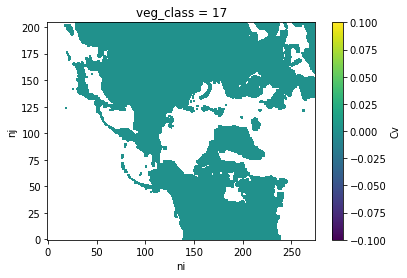

In [61]:
params['Cv'].isel(veg_class=16).plot()

In [62]:
veg_class_vars = ['Cv', 'trunk_ratio', 'rarc', 'rmin', 'wind_h', 'RGL', 'rad_atten',
                  'wind_atten', 'albedo', 'LAI', 'overstory',
                  'root_depth', 'root_fract', 'displacement', 'veg_rough']

for veg_class_var in veg_class_vars: 
    if ((veg_class_var == "LAI") or (veg_class_var == "albedo") or (veg_class_var == "root_depth") 
    or (veg_class_var == "root_fract") or (veg_class_var == "veg_rough") or 
        (veg_class_var == "displacement")):
        # bare = np.copy(params[veg_class_var].values[0, :, :, :])
        # last = np.copy(params[veg_class_var].values[16, :, :, :])
        bare = np.copy(params[veg_class_var].isel(veg_class=0))
        last = np.copy(params[veg_class_var].isel(veg_class=16))
        params[veg_class_var].values[0, :, :, :] = last
        params[veg_class_var].values[16, :, :, :] = bare
    else:
        # bare = np.copy(params[veg_class_var].values[0, :, :])
        # last = np.copy(params[veg_class_var].values[16, :, :])
        bare = np.copy(params[veg_class_var].isel(veg_class=0))
        last = np.copy(params[veg_class_var].isel(veg_class=16))
        params[veg_class_var].values[0, :, :] = last
        params[veg_class_var].values[16, :, :] = bare

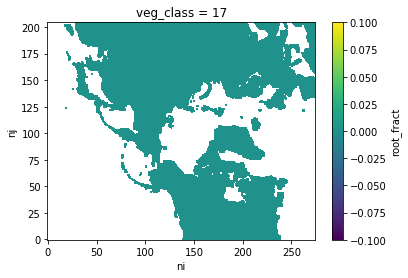

In [63]:
params['root_fract'].isel(veg_class=16).isel(root_zone=0).plot()

In [64]:
# adjust data vars that need adjusting 
params['Ksat'].values = params['Ksat'].where(domain.mask == 1)
params['expt'].values = params['expt'].where(domain.mask == 1)
params['bubble'].values = params['bubble'].where(domain.mask == 1)
params['Wpwp_FRACT'].values = params['Wpwp_FRACT'].where(domain.mask == 1)
params['Wcr_FRACT'].values = params['Wcr_FRACT'].where(domain.mask == 1)
params['resid_moist'].values = params['resid_moist'].where(domain.mask == 1)
params['quartz'].values = params['quartz'].where(domain.mask == 1)
params['bulk_density'].values = params['bulk_density'].where(domain.mask == 1)
params['soil_density'].values = params['soil_density'].where(domain.mask == 1)
params['c'].values = params['c'].where(domain.mask == 1)
params['snow_rough'].values = params['snow_rough'].where(domain.mask == 1)
params['Nveg'].values = params['Nveg'].where(domain.mask == 1)
params['trunk_ratio'] = params['trunk_ratio'].where(domain.mask == 1)
params['rarc'] = params['rarc'].where(domain.mask == 1)
params['rmin'] = params['rmin'].where(domain.mask == 1)
params['wind_h'] = params['wind_h'].where(domain.mask == 1)
params['RGL'] = params['RGL'].where(domain.mask == 1)
params['rad_atten'] = params['rad_atten'].where(domain.mask == 1)
params['wind_atten'] = params['wind_atten'].where(domain.mask == 1)
params['root_depth'] = params['root_depth'].where(domain.mask == 1)
params['root_fract'] = params['root_fract'].where(domain.mask == 1)
params['albedo'] = params['albedo'].where(domain.mask == 1)
params['LAI'] = params['LAI'].where(domain.mask == 1)
params['overstory'] = params['overstory'].where(domain.mask == 1)
params['displacement'] = params['displacement'].where(domain.mask == 1)
params['veg_rough'] = params['veg_rough'].where(domain.mask == 1)
params['elev'] = params['elev'].where(domain.mask == 1)
params['avg_T'] = params['avg_T'].where(domain.mask == 1)
params['annual_prec'] = params['annual_prec'].where(domain.mask == 1)
params['rough'] = params['rough'].where(domain.mask == 1)

In [65]:
encoding_params = {'run_cell': {'dtype': 'int32', "_FillValue": fillval_i}, 
                   'gridcell': {'dtype': 'int32', "_FillValue": fillval_i}, 
                   'fs_active': {'dtype': 'int32', "_FillValue": fillval_i}, 
                   'Nveg': {'dtype': 'int32', "_FillValue": fillval_i},
                   'overstory': {'dtype': 'int32', "_FillValue": fillval_i},
                   'veg_class': {'dtype': 'int32'}}
direc = '/u/home/gergel/data/parameters'
new_params_file = os.path.join(direc, 'new_vic5_params_20180726.nc')
params.to_netcdf(new_params_file, format='NETCDF4_CLASSIC', encoding=encoding_params)
print("saved new parameters to %s" %new_params_file)

saved new parameters to /u/home/gergel/data/parameters/new_vic5_params_20180726.nc


In [66]:
'''vc = 5
month = 8
disp = params['displacement'].isel(month=month).isel(veg_class=vc)
height = disp / 0.67
trunk = params['trunk_ratio'].isel(veg_class=vc)
zt = trunk * height
Z0_SOIL = params['rough']'''

"vc = 5\nmonth = 8\ndisp = params['displacement'].isel(month=month).isel(veg_class=vc)\nheight = disp / 0.67\ntrunk = params['trunk_ratio'].isel(veg_class=vc)\nzt = trunk * height\nZ0_SOIL = params['rough']"

In [67]:
# (zt < Z0_SOIL).sum()
# disp.plot()

In [68]:
# params.Cv.isel(veg_class=16).plot()
# params.veg_class
# disp.plot()